In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
mnase = pd.read_hdf('data/mnase_seq_merged_sampled.h5.z')

In [8]:
orfs = pd.read_csv('data/orfs_cd_paper_dataset.csv').set_index('orf_name')

In [204]:
mnase_0 = mnase[mnase.time == 0.0]

In [492]:
len_span = (30, 250)

img, smoothed, img_t = create_gene_image(orfs.loc[orfs.index.values[0]], mnase_0, window, len_span, img_size)

In [ ]:
desc, data_120 = read_pickle('data/mnase_10x100_DM1129_preind_wt_rep1.pkl')

In [531]:
def plot_grid():
    lens = [30, 80, 130, 200]
    pos = np.linspace(-500, 500, 21)

    for l in lens:
        plt.axhline(l, c='gray', lw=1, alpha=0.5)
        
    for p in pos:
        plt.axvline(p, c='gray', lw=1, alpha=0.5)

    plt.yticks(lens)


In [529]:
def plot_img(img, extent=[-500, 500, 30, 250]):
    plt.imshow(img, cmap='magma_r', vmax=0.25, origin='lower', extent=extent, aspect='auto')
    plt.xticks([])
    plot_grid()
    plt.ylim(20, 225)

In [495]:
gene = orfs.loc[orfs.index.values[0]]
gene_mnase = filter_mnase(mnase, span[0], span[1], gene.chr)

cur_mnase = gene_mnase[gene_mnase.time == 0].copy()
cur_mnase.mid = cur_mnase.mid - gene.TSS

if gene.strand == '-':
    cur_mnase.mid = -cur_mnase.mid

In [488]:
def subselect_resize(smoothed, len_subselect, resize_size):
    smooth_sub = smoothed.loc[len_subselect[0]:len_subselect[1]-1]
    img_t = cv2.resize(smooth_sub.values, (resize_size[1], resize_size[0]))
    return smooth_sub, img_t


In [514]:
from scipy.signal import convolve2d
from src.transformations import exhaustive_counts

win_2 = window//2
span = gene.TSS-win_2, gene.TSS+win_2

img = exhaustive_counts(cur_mnase, 
        (-win_2, win_2), len_span, x_key='mid', y_key='length')

kernel = normal_2d_kernel(5, 15, 20, 30)
smoothed = convolve2d(img.loc[len_span[0]:len_span[1]], kernel, mode='same')
lens = np.arange(len_span[0], len_span[1])

smoothed = pd.DataFrame(smoothed, index=lens, columns=np.arange(-win_2, win_2+1))


In [499]:
def subselect_resize(smoothed, len_subselect, resize_size):
    smooth_sub = smoothed.loc[len_subselect[0]:len_subselect[1]-1]
    img_t = cv2.resize(smooth_sub.values, (resize_size[1], resize_size[0]))
    return smooth_sub, img_t

def foo(smoothed, len_cuts, sublen_size, pos_resize):

    ret = []
    for i in range(1, len(len_cuts)):
        len_subselect = (len_cuts[i-1], len_cuts[i])
        smooth_sub, img_t = subselect_resize(smoothed, len_subselect, (sublen_size, pos_resize))
        ret.append((len_subselect, smooth_sub, img_t))

    return ret

In [518]:
len_span

(30, 250)

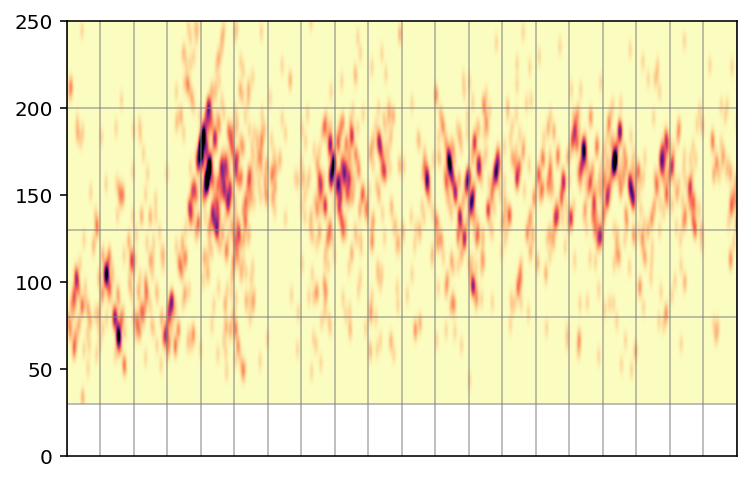

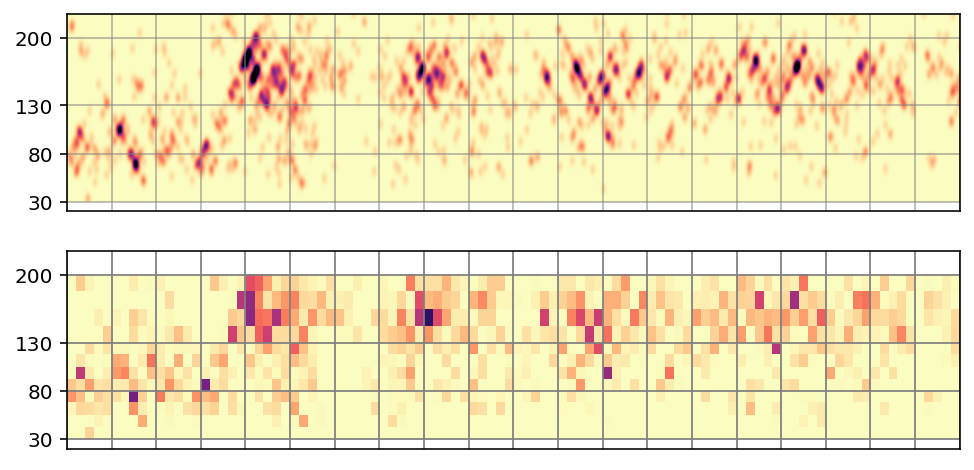

In [532]:
ret = foo(smoothed, [30, 80, 130, 201], 4, img_size[1])

plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plot_img(smoothed, extent=[-win_2, win_2, *len_span])

plt.subplot(2, 1, 2)
for i in range(len(ret)):
    len_sel, cur_smooth, cur_img = ret[i]
    plot_img(cur_img, extent=[-win_2, win_2, *len_sel])
